In [2]:
import numpy as np
import matplotlib.pylab as plt

In [8]:
rssi_measured = np.array([-66,-67,-62,-69,-65,-72])
xs = np.array(range(rssi_measured.size))
ys = rssi_measured

Text(0, 0.5, 'RSSI value (dBm)')

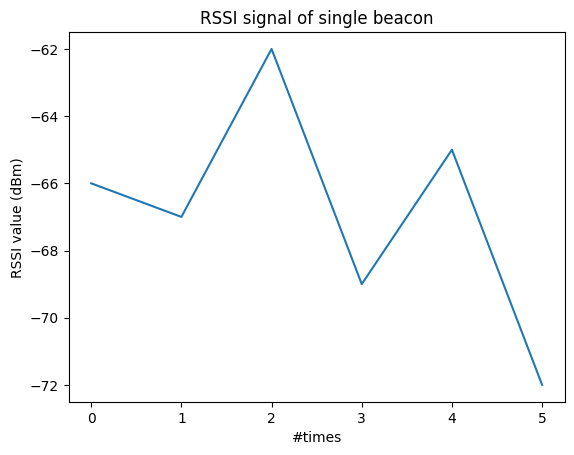

In [12]:
plt.plot(xs,ys)
plt.title('RSSI signal of single beacon')
plt.xlabel('#times')
plt.ylabel('RSSI value (dBm)')
